In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import datetime
import numpy as np
import ml_metrics
from pmdarima.arima import auto_arima

In [4]:
data = pd.read_csv('AirPassengers.csv')

In [5]:
data.columns = ['Date', 'Passengers']

In [6]:
data.index = data['Date']
del data['Date']

In [7]:
data.head()

,Passengers
Date,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [8]:
data.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
data.isna().sum()

Passengers    0
dtype: int64

In [10]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean() 
    rolstd = timeseries.rolling(window=12).std() 
    plt.rcParams["figure.figsize"] = (15,15)
    plt.plot(timeseries, color = 'green', label = 'true data')
    plt.plot(rolmean, color = 'red', label = 'rolling mean')
    plt.plot(rolstd, color = 'black', label = 'std')
    plt.show()

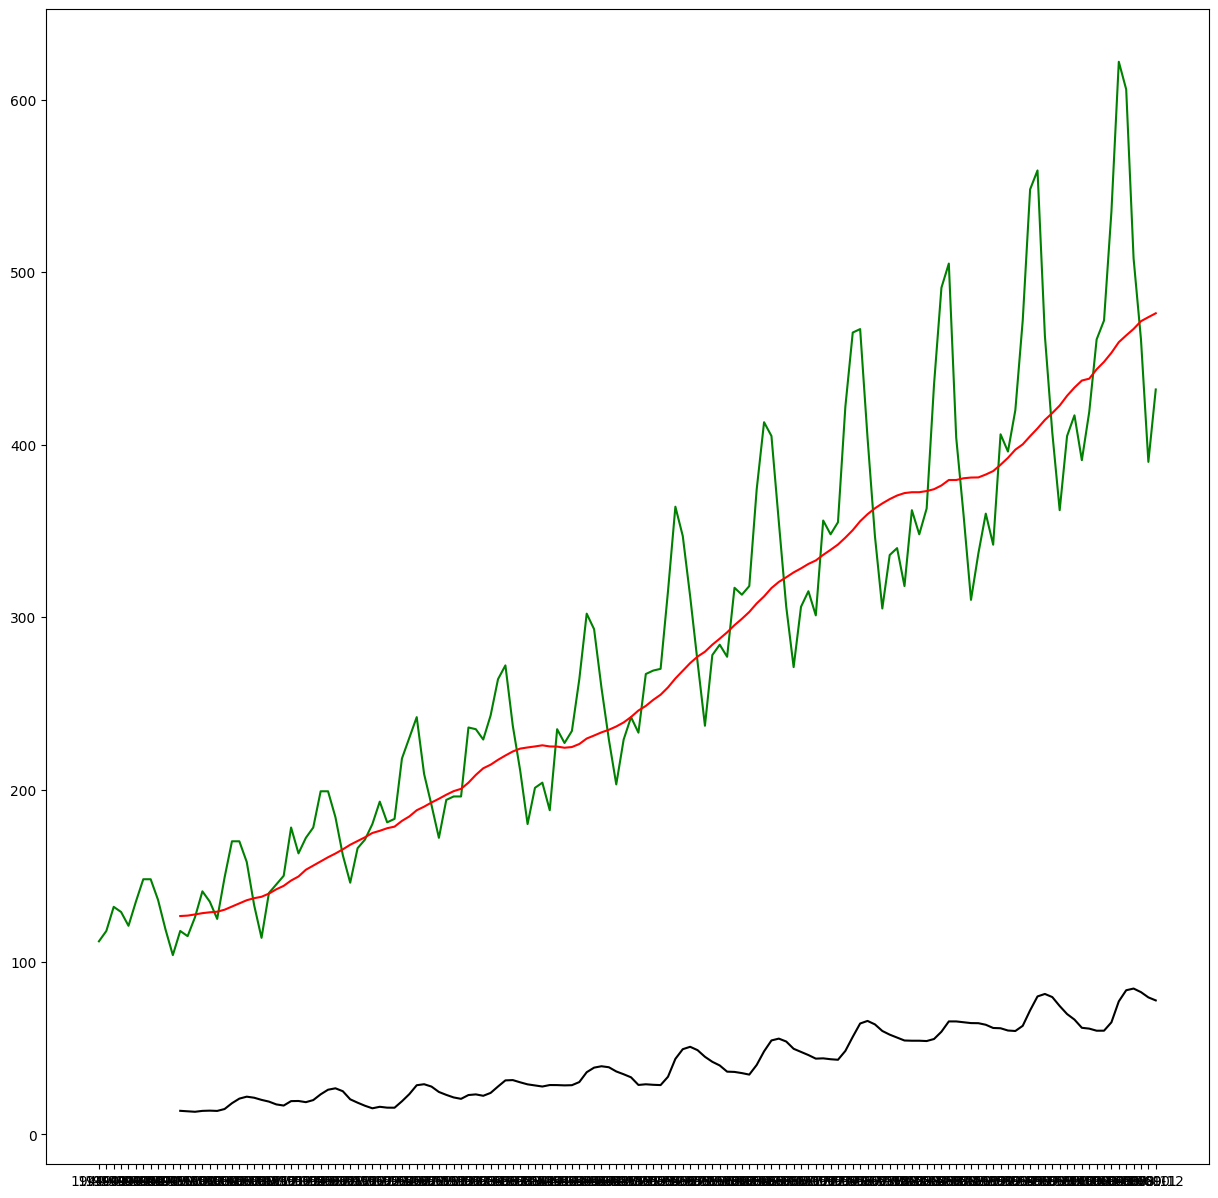

In [11]:
test_stationarity(data)

In [12]:
def test_s(data):
    test_stat = adfuller(data)
    if test_stat[0] < test_stat[4]['10%']:
        print(f"p-value {test_stat[1]}, critical values: {test_stat[4]},\n stationary time series")
    else:
        print(f"p-value {test_stat[1]}, critical values: {test_stat[4]}, \n NOT stationary time series")

In [13]:
test_s(data)

p-value 0.9918802434376409, critical values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}, 
 NOT stationary time series


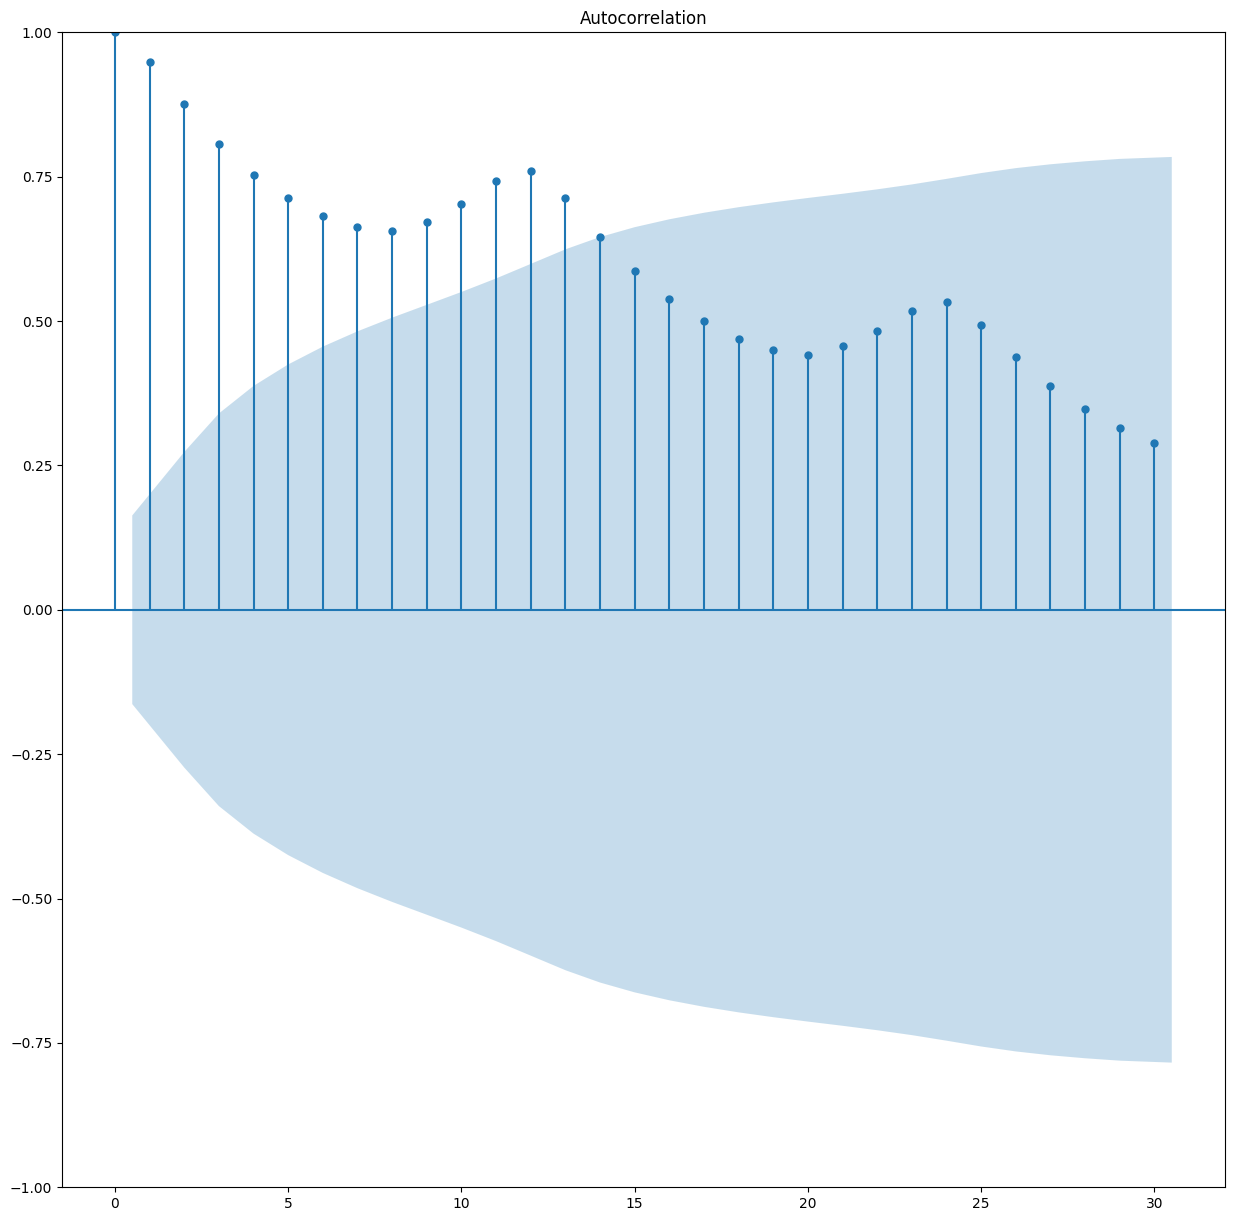

In [14]:
autocorr = plot_acf(data, lags=30)
plt.show()

- data has a high correcation and the frequency of seasonality which we can see from plot is 12

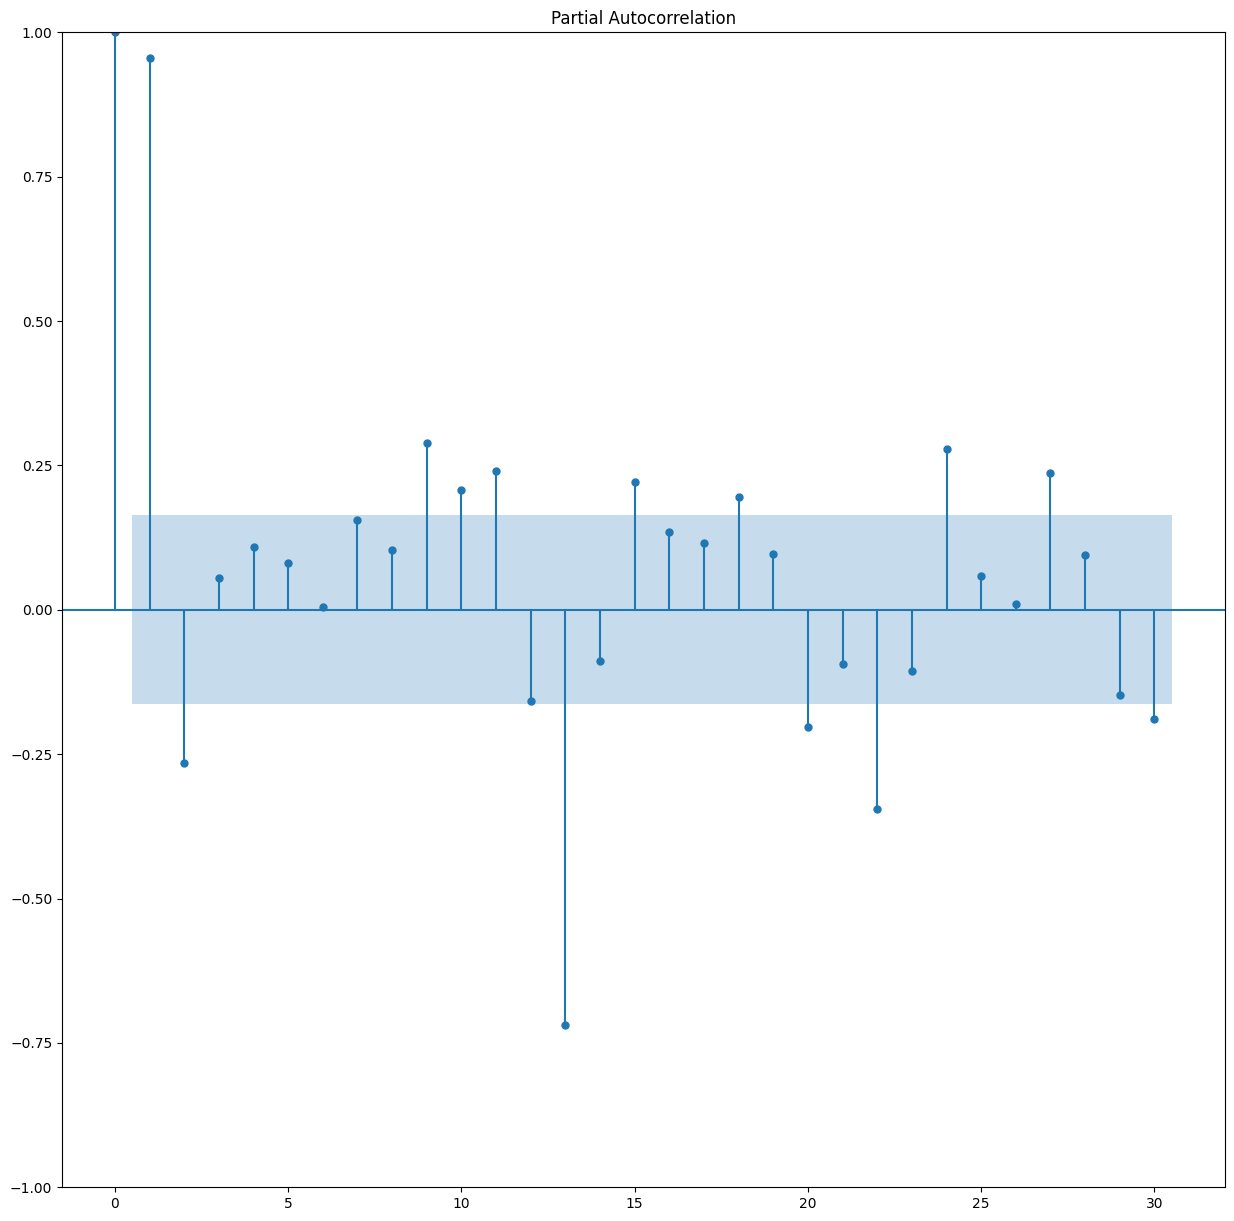

In [15]:
partcorr = plot_pacf(data, lags=30)
plt.show()

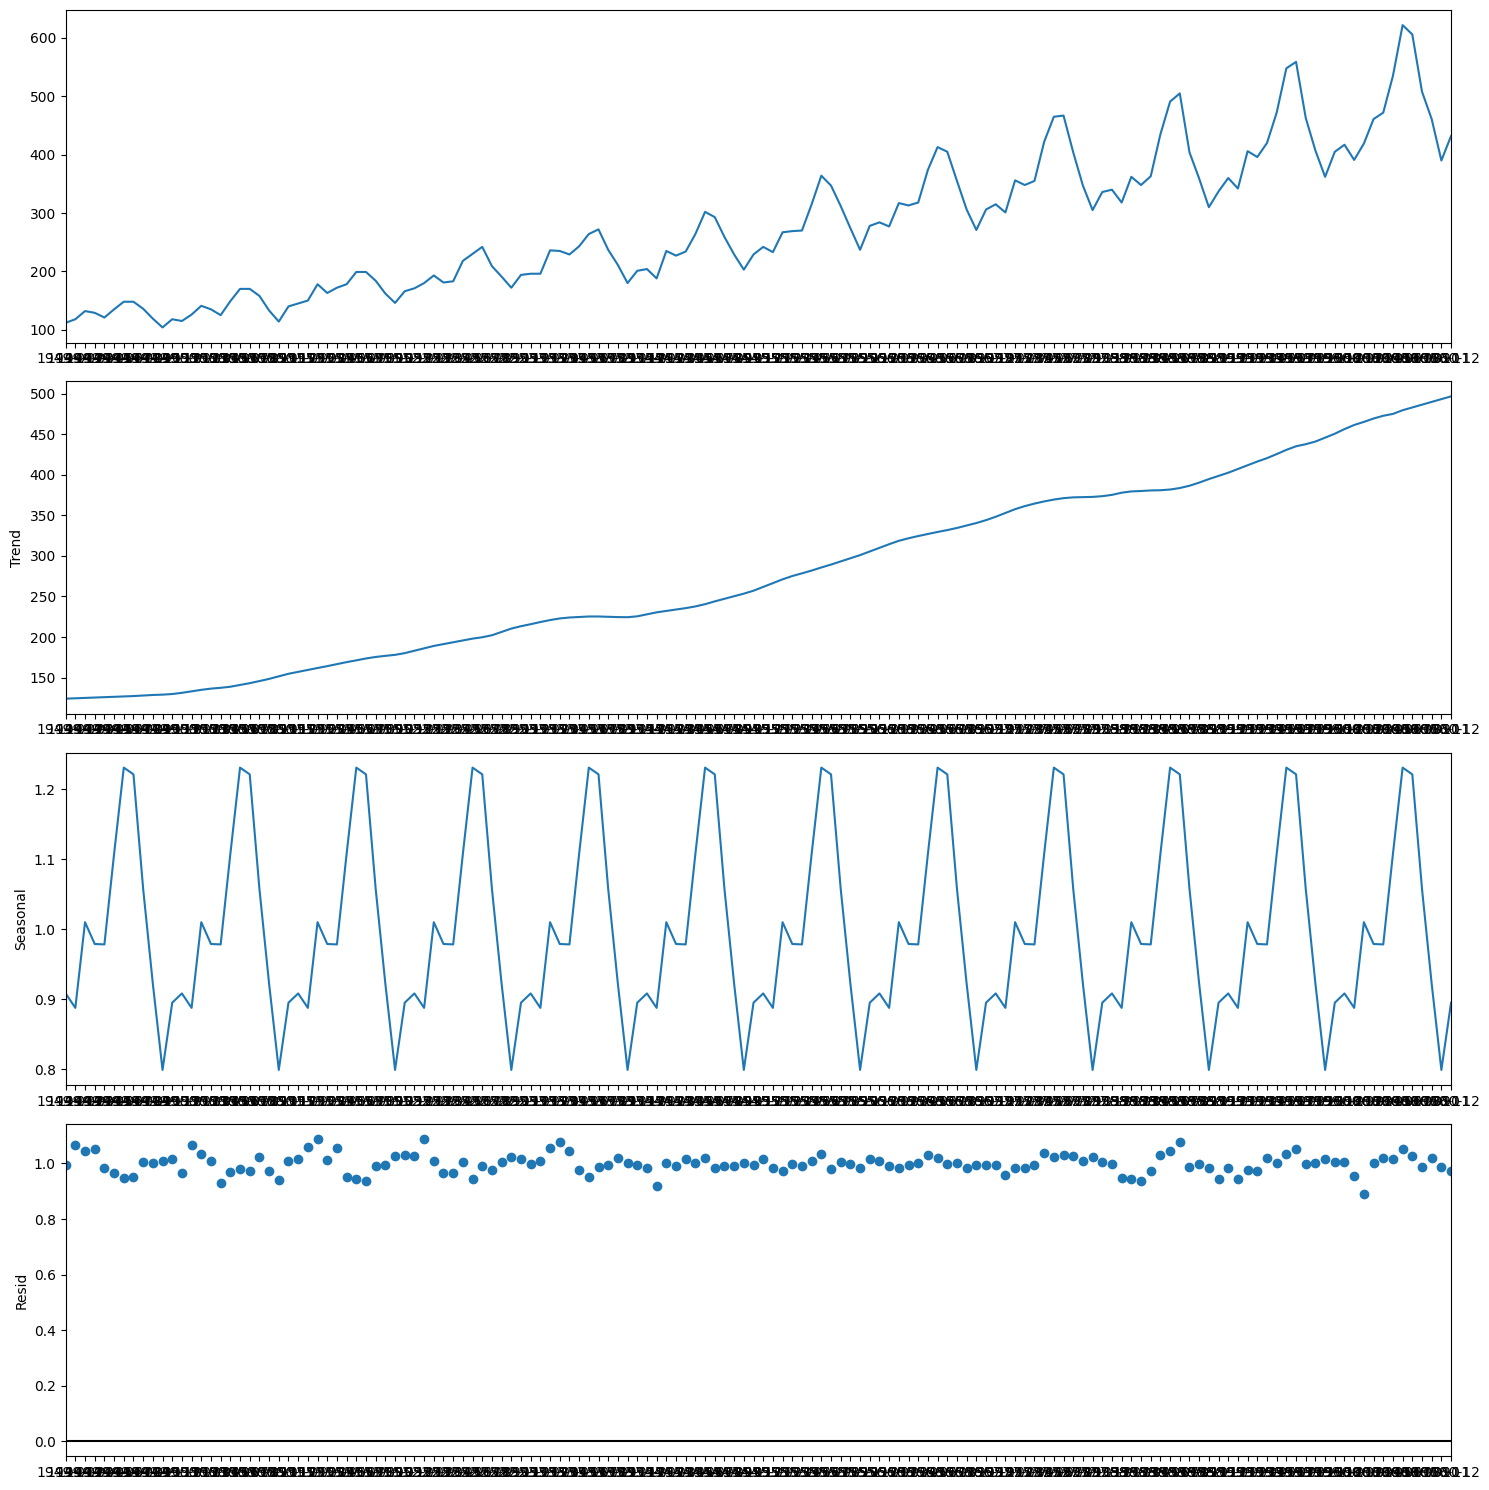

In [16]:
decompose_result_mult = seasonal_decompose(data, model="multiplicative", extrapolate_trend = True, period = 12)
decompose_result_mult.plot()
plt.show()

______

In [17]:
train_data = data[:-20]
test_data = data[-20:]

In [18]:
expo = ExponentialSmoothing(train_data, trend = 'mul', seasonal = 'mul')

In [19]:
model_fitted = expo.fit()

In [20]:
test_data.tail()

,Passengers
Date,
1960-08,606
1960-09,508
1960-10,461
1960-11,390
1960-12,432


In [21]:
forecast_test = model_fitted.forecast(steps = 20)

In [22]:
d = {'predict':forecast_test}
predicted_data_test = pd.DataFrame(data = d)
predicted_data_test.index = predicted_data_test.index.strftime("%Y-%m")

In [23]:
forecast_new = model_fitted.forecast(steps = 60)
d_new = {'predict':forecast_new}
predicted_data_new = pd.DataFrame(data = d_new)
predicted_data_new.index = predicted_data_new.index.strftime("%Y-%m")

In [24]:
date = pd.date_range(start="2053-01", end="2064-03")
date = date.strftime("%Y-%m")
date

Index(['2053-01', '2053-01', '2053-01', '2053-01', '2053-01', '2053-01',
       '2053-01', '2053-01', '2053-01', '2053-01',
       ...
       '2064-02', '2064-02', '2064-02', '2064-02', '2064-02', '2064-02',
       '2064-02', '2064-02', '2064-02', '2064-03'],
      dtype='object', length=4078)

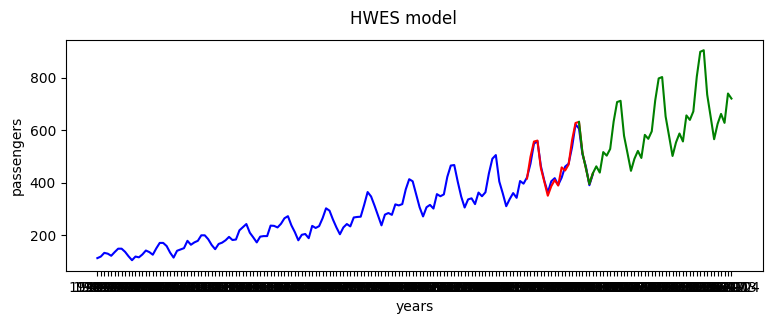

In [25]:
plt.figure(figsize=(9, 3))
plt.plot(data, color = 'blue', label="original")
plt.plot(predicted_data_test, color = 'red', label='predict test')
plt.plot(predicted_data_new[15:], color = 'green', label='predict test')
plt.xlabel('years')
plt.ylabel('passengers')
plt.suptitle('HWES model')
plt.show()

____

In [26]:
arima_model = auto_arima(train_data, seasonal=True, m=12, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=843.414, Time=1.15 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=942.581, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=841.692, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=890.316, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1100.615, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=841.349, Time=0.05 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=841.921, Time=0.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=841.844, Time=0.09 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=842.275, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=889.425, Time=0.07 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=842.600, Time=0.26 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=849.916, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 3.155 seconds


In [27]:
model_sarima = sm.tsa.statespace.SARIMAX(train_data, order=(1, 0, 0), seasonal_order=(0, 1 ,0, 12))

In [28]:
result_sarimax = model_sarima.fit()

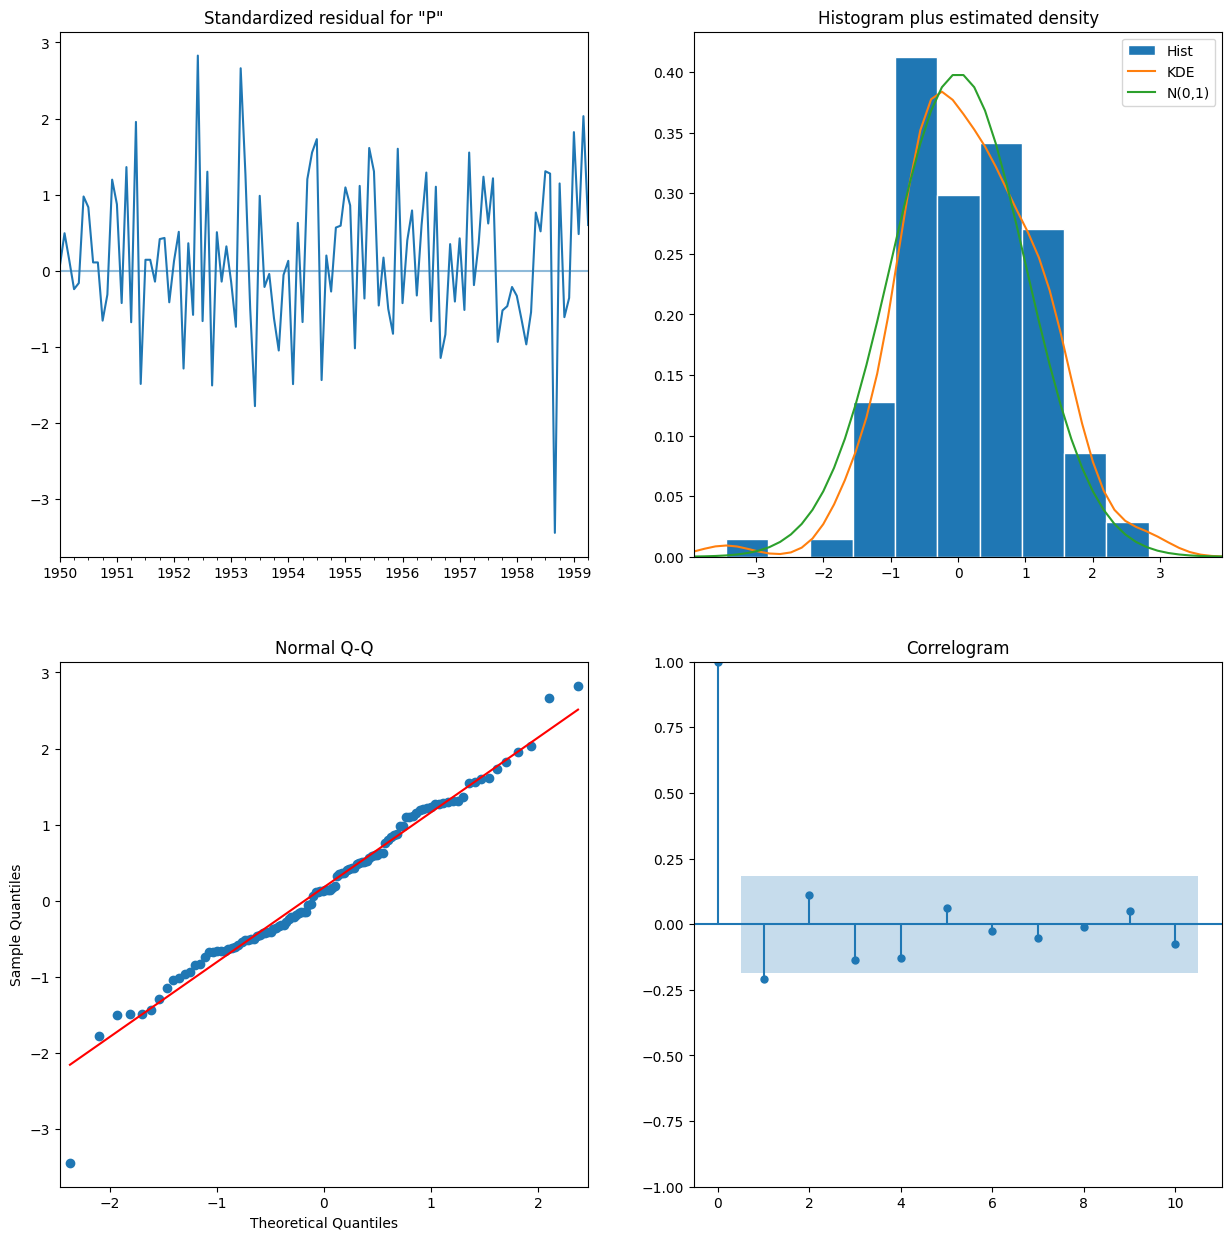

In [29]:
result_sarimax.plot_diagnostics()
plt.show()

In [30]:
predicted_test = result_sarimax.get_prediction(start='1959-05', end='1960-12')

In [31]:
predicted_new = result_sarimax.get_prediction(start='1960-12', end='1964-03')

In [32]:
predicted_new_forecast = predicted_new.predicted_mean.values
predicted_new_years = predicted_new.predicted_mean.index.strftime("%Y-%m")

In [33]:
test_forecast = predicted_test.predicted_mean.values
years_forecast = predicted_test.predicted_mean.index.strftime("%Y-%m")

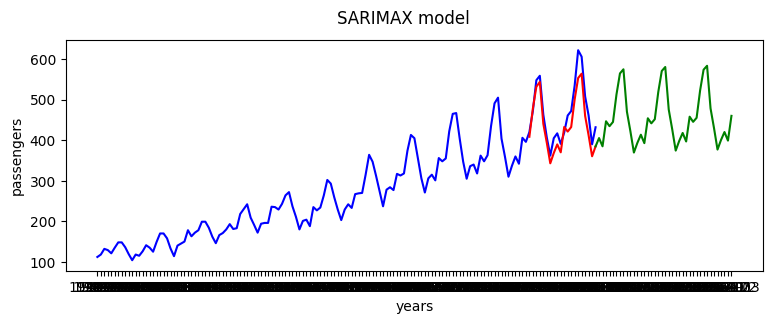

In [34]:
plt.figure(figsize=(9, 3))
plt.plot(data, color = 'blue', label="original")
plt.plot(years_forecast, test_forecast, color = 'red', label='predict test')
plt.plot(predicted_new_years, predicted_new_forecast, color = 'green', label='predict test')
plt.xlabel('years')
plt.ylabel('passengers')
plt.suptitle('SARIMAX model')
plt.show()

In [35]:
def metrics(real, forecast):
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

- SARIMAX:

In [36]:
metrics(test_data.values, test_forecast)

MAD: 80.9883
MSE: 10381.168
MAPE: 0.168
MPE: 0.0389
Стандартна похибка: 101.888


- HWES:

In [37]:
metrics(test_data.values, forecast_test.values)

MAD: 84.4741
MSE: 11400.2572
MAPE: 0.1808
MPE: -0.0293
Стандартна похибка: 106.772


- Хоч за побудованими графіками модель HWES виглядає краще, але за отриманими метриками тестових даних, можна сказати, що SARIMAX дає незначні, але кращі результати. 